In [2]:
import sys
import os
sys.path.append(os.path.abspath('..'))
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


from features import extract_features_per_cycle

In [3]:
def load_and_extract_features(ps2_path, fs1_path, profile_path):
    # Load raw signals
    ps2 = pd.read_csv(ps2_path, sep='\t', header=None)
    fs1 = pd.read_csv(fs1_path, sep='\t', header=None)
    profile = pd.read_csv(profile_path, sep='\t', header=None)

    profile.columns = ['cooler_cond', 'valve_cond', 'pump_leakage', 'accumulator_press', 'stable_flag']
    y = (profile['valve_cond'] == 100).astype(int)

    feature_list = []

    for i in tqdm(range(len(profile)), desc="Extracting features"):
        ps2_cycle = ps2.iloc[i]
        fs1_cycle = fs1.iloc[i]
        features = extract_features_per_cycle(ps2_cycle, fs1_cycle)
        feature_list.append(features)

    X = pd.DataFrame(feature_list)
    return X, y


In [4]:
# Build from raw .txt files
X_train, y_train = load_and_extract_features(
    'data/train/ps2_train.txt',
    'data/train/fs1_train.txt',
    'data/train/profile_train.txt'
)

X_test, y_test = load_and_extract_features(
    'data/test/ps2_test.txt',
    'data/test/fs1_test.txt',
    'data/test/profile_test.txt'
)

print("Data ready:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)


Extracting features: 100%|██████████| 205/205 [00:00<00:00, 264.99it/s]

Data ready:
X_train: (2000, 20)
y_train: (2000,)


In [5]:
def train_and_evaluate(model, name, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)

    print(f"\n Model: {name}")
    print(classification_report(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix: {name}")
    plt.show()

    # Save model
    os.makedirs('models', exist_ok=True)
    joblib.dump(model, f'models/{name}.pkl')

    return {
        "model": name,
        "accuracy": acc,
        "f1_score": f1,
        "precision": prec,
        "recall": rec
    }



 Model: LogisticRegression
              precision    recall  f1-score   support

           0       1.00      0.91      0.95       132
           1       0.86      1.00      0.92        73

    accuracy                           0.94       205
   macro avg       0.93      0.95      0.94       205
weighted avg       0.95      0.94      0.94       205



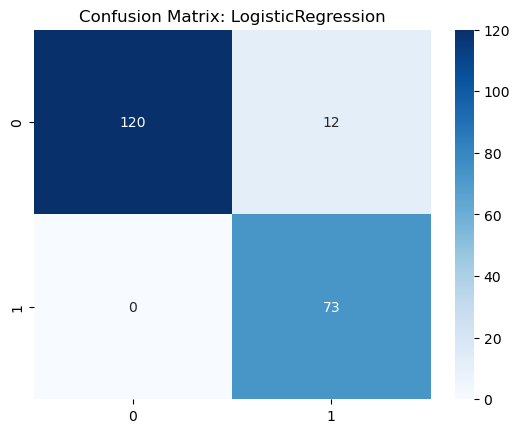


 Model: RandomForest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       132
           1       1.00      1.00      1.00        73

    accuracy                           1.00       205
   macro avg       1.00      1.00      1.00       205
weighted avg       1.00      1.00      1.00       205



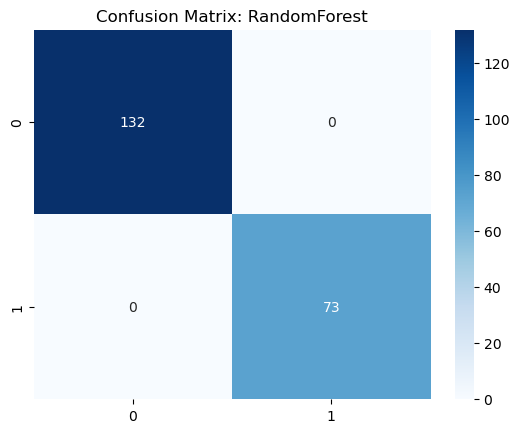

c:\Users\Admin\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [19:02:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 Model: XGBoost
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       132
           1       1.00      1.00      1.00        73

    accuracy                           1.00       205
   macro avg       1.00      1.00      1.00       205
weighted avg       1.00      1.00      1.00       205



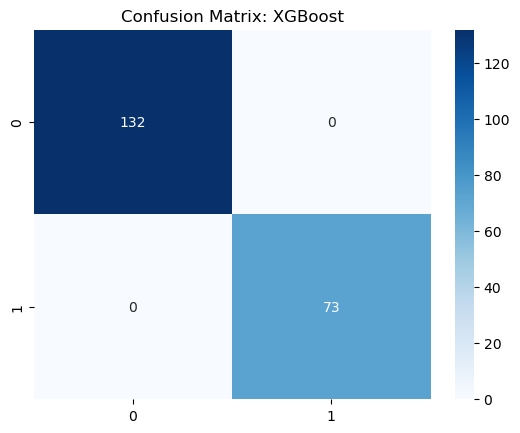


 Model: SVM
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       132
           1       0.36      1.00      0.53        73

    accuracy                           0.36       205
   macro avg       0.18      0.50      0.26       205
weighted avg       0.13      0.36      0.19       205



c:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


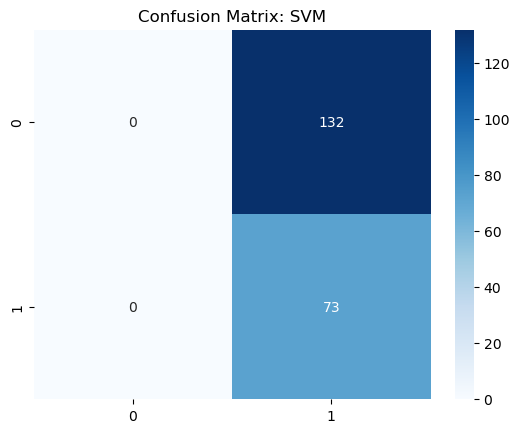


 Model: KNN
              precision    recall  f1-score   support

           0       1.00      0.82      0.90       132
           1       0.75      1.00      0.86        73

    accuracy                           0.88       205
   macro avg       0.88      0.91      0.88       205
weighted avg       0.91      0.88      0.89       205



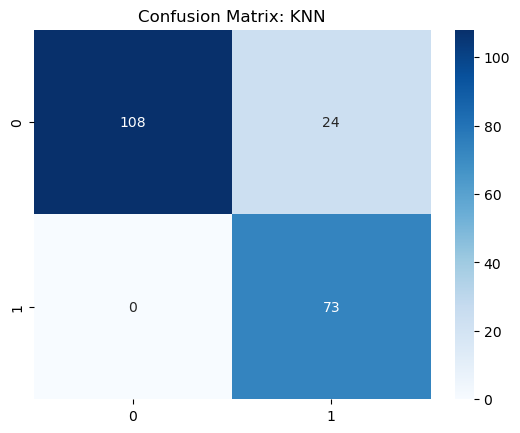

In [6]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier()
}

results = []
for name, model in models.items():
    result = train_and_evaluate(model, name, X_train, y_train, X_test, y_test)
    results.append(result)

In [7]:
results_df = pd.DataFrame(results).sort_values(by="f1_score", ascending=False)
display(results_df)

# Optional: Save comparison
results_df.to_csv("models/model_comparison.txt", index=False)

# Best model name
best_model_name = results_df.iloc[0]['model']
print(f"\n Best model: {best_model_name}")

,model,accuracy,f1_score,precision,recall
1,RandomForest,1.000000,1.000000,1.000000,1.0
2,XGBoost,1.000000,1.000000,1.000000,1.0
0,LogisticRegression,0.941463,0.924051,0.858824,1.0
4,KNN,0.882927,0.858824,0.752577,1.0
3,SVM,0.356098,0.525180,0.356098,1.0



 Best model: RandomForest
